# Final Project Code

In [ ]:
#load libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import missingno
from mpl_toolkits.mplot3d import Axes3D
from sklearn.feature_extraction.text import CountVectorizer
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import collections
from collections import Counter
import string
import re
from wordcloud import WordCloud
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk import bigrams
from pprint import pprint
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, cross_val_score, RepeatedStratifiedKFold
from sklearn.preprocessing import PowerTransformer, OneHotEncoder
from sklearn.compose import ColumnTransformer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, GRU, Dropout
from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint

# View all columns and rows
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 90) # set to fit 90 column descriptions

# Set up notebook to display multiple outputs in one cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [ ]:
tweets_df = pd.read_csv('/content/tweets.csv')

## EDA

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

tweet_id airline_sentiment  airline_sentiment_confidence  \
0  570306133677760513           neutral                        1.0000   
1  570301130888122368          positive                        0.3486   
2  570301083672813571           neutral                        0.6837   
3  570301031407624196          negative                        1.0000   
4  570300817074462722          negative                        1.0000   

  negativereason  negativereason_confidence         airline  \
0            NaN                        NaN  Virgin America   
1            NaN                     0.0000  Virgin America   
2            NaN                        NaN  Virgin America   
3     Bad Flight                     0.7033  Virgin America   
4     Can't Tell                     1.0000  Virgin America   

  airline_sentiment_gold        name negativereason_gold  retweet_count  \
0                    NaN     cairdin                 NaN              0   
1                    NaN    jnardino                 NaN              0   
2                    NaN  yvonnalynn                 NaN              0   
3                    NaN    jnardino                 NaN              0   
4                    NaN    jnardino                 NaN              0   

                                                text tweet_coord  \
0                @VirginAmerica What @dhepburn said.         NaN   
1  @VirginAmerica plus you've added commercials t...         NaN   
2  @VirginAmerica I didn't today... Must mean I n...         NaN   
3  @VirginAmerica it's really aggressive to blast...         NaN   
4  @VirginAmerica and it's a really big bad thing...         NaN   

               tweet_created tweet_location               user_timezone  
0  2015-02-24 11:35:52 -0800            NaN  Eastern Time (US & Canada)  
1  2015-02-24 11:15:59 -0800            NaN  Pacific Time (US & Canada)  
2  2015-02-24 11:15:48 -0800      Lets Play  Central Time (US & Canada)  
3  2015-02-24 11:15:36 -0800            NaN  Pacific Time (US & Canada)  
4  2015-02-24 11:14:45 -0800            NaN  Pacific Time (US & Canada)

tweet_id  airline_sentiment_confidence  negativereason_confidence  \
count  1.464000e+04                  14640.000000               10522.000000   
mean   5.692184e+17                      0.900169                   0.638298   
std    7.791112e+14                      0.162830                   0.330440   
min    5.675883e+17                      0.335000                   0.000000   
25%    5.685592e+17                      0.692300                   0.360600   
50%    5.694779e+17                      1.000000                   0.670600   
75%    5.698905e+17                      1.000000                   1.000000   
max    5.703106e+17                      1.000000                   1.000000   

       retweet_count  
count   14640.000000  
mean        0.082650  
std         0.745778  
min         0.000000  
25%         0.000000  
50%         0.000000  
75%         0.000000  
max        44.000000

tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5462
negativereason_confidence        4118
airline                             0
airline_sentiment_gold          14600
name                                0
negativereason_gold             14608
retweet_count                       0
text                                0
tweet_coord                     13621
tweet_created                       0
tweet_location                   4733
user_timezone                    4820
dtype: int64

<Axes: >

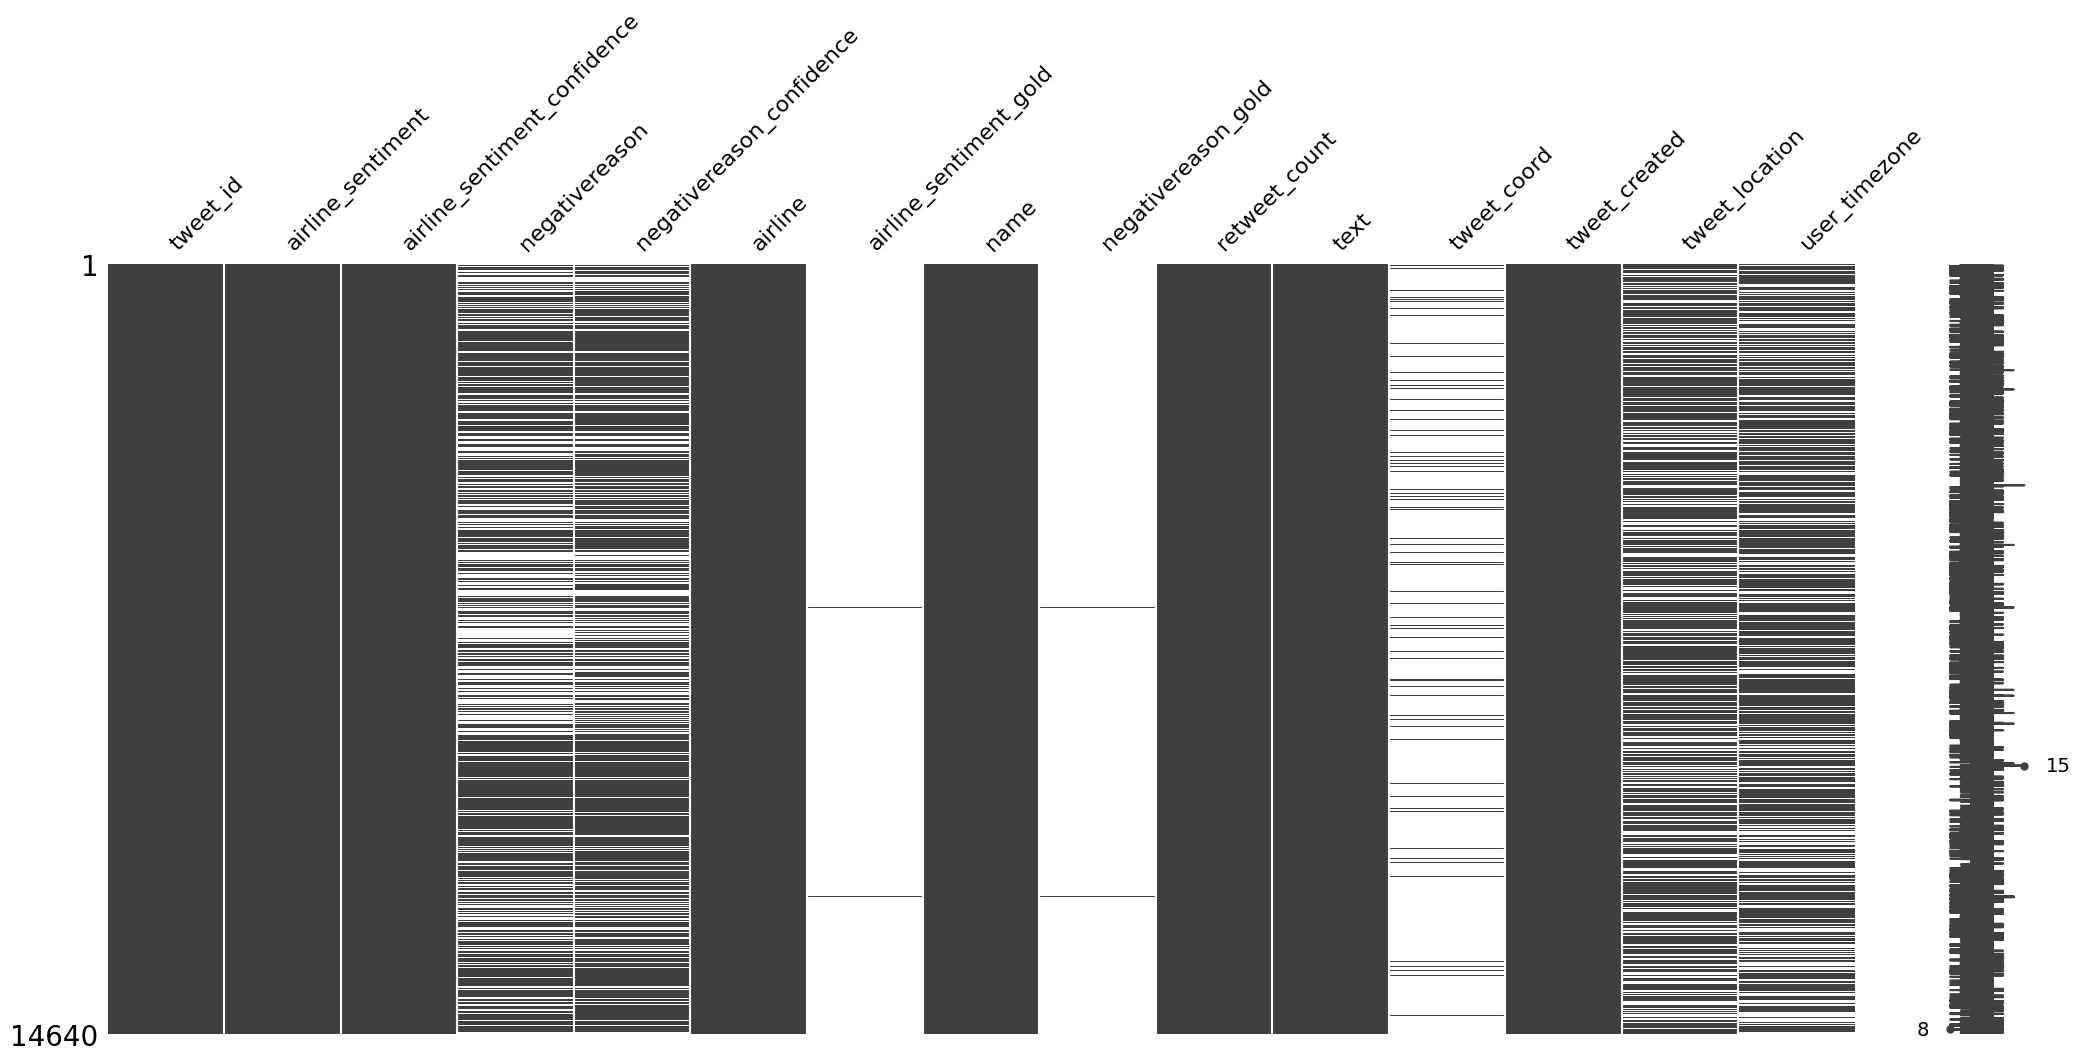

In [ ]:
# Inspect dataset

## Inspect columns and variable types
tweets_df.info()

## View dataframe rows
tweets_df.head()

## View summary statistics
tweets_df.describe()

## View missing values
tweets_df.isnull().sum()

## Plot missing values
missingno.matrix(tweets_df)

In [ ]:
# Convert airline_sentiment classification to numeric: positive, neutral, negative = 1, 0, -1
tweets_df['numeric_sentiment'] = tweets_df.apply(lambda x: 1 if (x['airline_sentiment'] == 'positive') else 0 if (x['airline_sentiment'] == 'neutral') else -1, axis = 1)

# Create weighted_sentiment feature, the product of the sentiment and the confidence.
tweets_df['weighted_sentiment'] = tweets_df['numeric_sentiment'] * tweets_df['airline_sentiment_confidence']

In [ ]:
# Compute summary statistics for numeric_sentiment variable.

print("Summary stats for numeric_sentiment.")
tweets_df['numeric_sentiment'].describe()

print("Median and mode for numeric_sentiment.")
tweets_df['numeric_sentiment'].median()
tweets_df['numeric_sentiment'].mode().iloc[0] # Taking first mode if multiple.

print("Summary stats for weighted_sentiment.")
tweets_df['weighted_sentiment'].describe()

print("Median and mode for weighted_sentiment.")
tweets_df['weighted_sentiment'].median()
tweets_df['weighted_sentiment'].mode().iloc[0] # Taking first mode if multiple.

## Noting that the 'numeric_sentiment' and 'weighted_sentiment' columns are predominantly negative.

Summary stats for numeric_sentiment.


count    14640.000000
mean        -0.465505
std          0.756084
min         -1.000000
25%         -1.000000
50%         -1.000000
75%          0.000000
max          1.000000
Name: numeric_sentiment, dtype: float64

Median and mode for numeric_sentiment.


-1.0

-1

Summary stats for weighted_sentiment.


count    14640.000000
mean        -0.444385
std          0.698999
min         -1.000000
25%         -1.000000
50%         -1.000000
75%          0.000000
max          1.000000
Name: weighted_sentiment, dtype: float64

Median and mode for weighted_sentiment.


-1.0

-1.0

array([[<Axes: title={'center': '-1'}>, <Axes: title={'center': '0'}>],
       [<Axes: title={'center': '1'}>, <Axes: >]], dtype=object)

array([[<Axes: title={'center': 'American'}>,
        <Axes: title={'center': 'Delta'}>],
       [<Axes: title={'center': 'Southwest'}>,
        <Axes: title={'center': 'US Airways'}>],
       [<Axes: title={'center': 'United'}>,
        <Axes: title={'center': 'Virgin America'}>]], dtype=object)

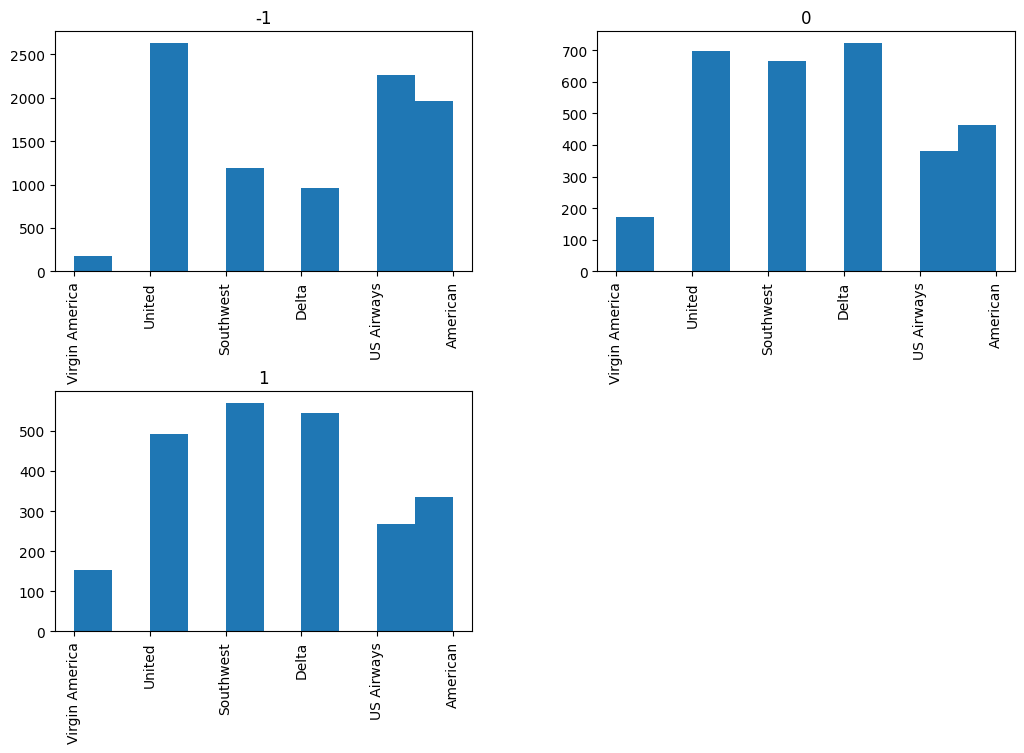

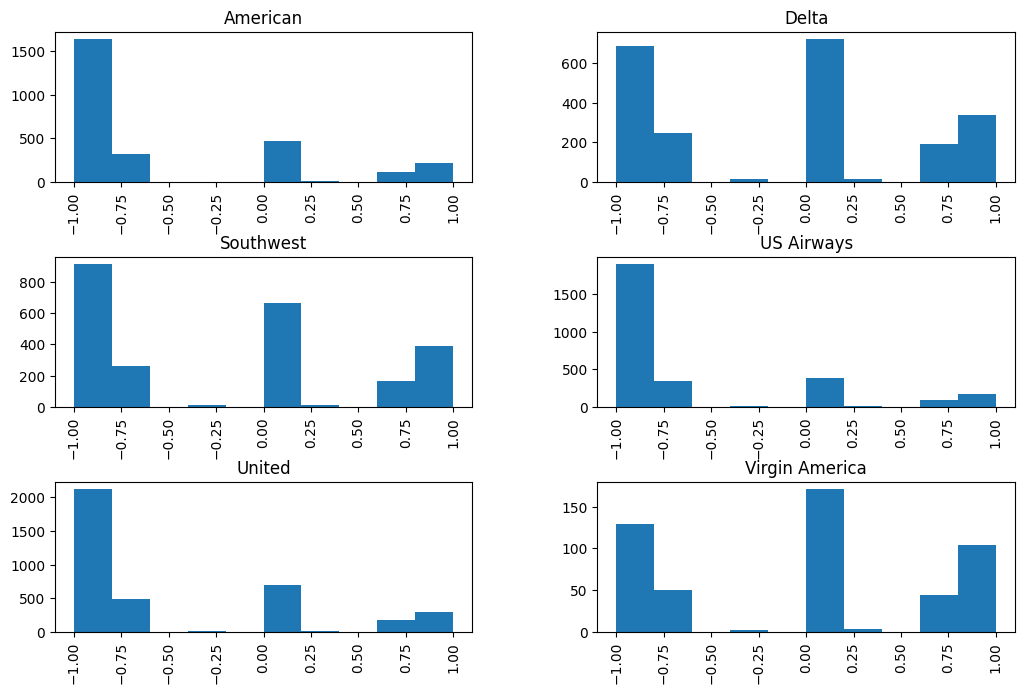

In [ ]:
# look at Airline Sentiment distribution
tweets_df.hist(column ='airline', by='numeric_sentiment',figsize=(12,8))
tweets_df.hist(column ='weighted_sentiment', by='airline',figsize=(12,8))
#sns.histplot(data_df,x = 'airline',hue = 'num_sentiment')
#plt.show()

array([[<Axes: title={'center': 'Bad Flight'}>,
        <Axes: title={'center': "Can't Tell"}>,
        <Axes: title={'center': 'Cancelled Flight'}>],
       [<Axes: title={'center': 'Customer Service Issue'}>,
        <Axes: title={'center': 'Damaged Luggage'}>,
        <Axes: title={'center': 'Flight Attendant Complaints'}>],
       [<Axes: title={'center': 'Flight Booking Problems'}>,
        <Axes: title={'center': 'Late Flight'}>,
        <Axes: title={'center': 'Lost Luggage'}>],
       [<Axes: title={'center': 'longlines'}>, <Axes: >, <Axes: >]],
      dtype=object)

array([[<Axes: title={'center': 'Bad Flight'}>,
        <Axes: title={'center': "Can't Tell"}>,
        <Axes: title={'center': 'Cancelled Flight'}>],
       [<Axes: title={'center': 'Customer Service Issue'}>,
        <Axes: title={'center': 'Damaged Luggage'}>,
        <Axes: title={'center': 'Flight Attendant Complaints'}>],
       [<Axes: title={'center': 'Flight Booking Problems'}>,
        <Axes: title={'center': 'Late Flight'}>,
        <Axes: title={'center': 'Lost Luggage'}>],
       [<Axes: title={'center': 'longlines'}>, <Axes: >, <Axes: >]],
      dtype=object)

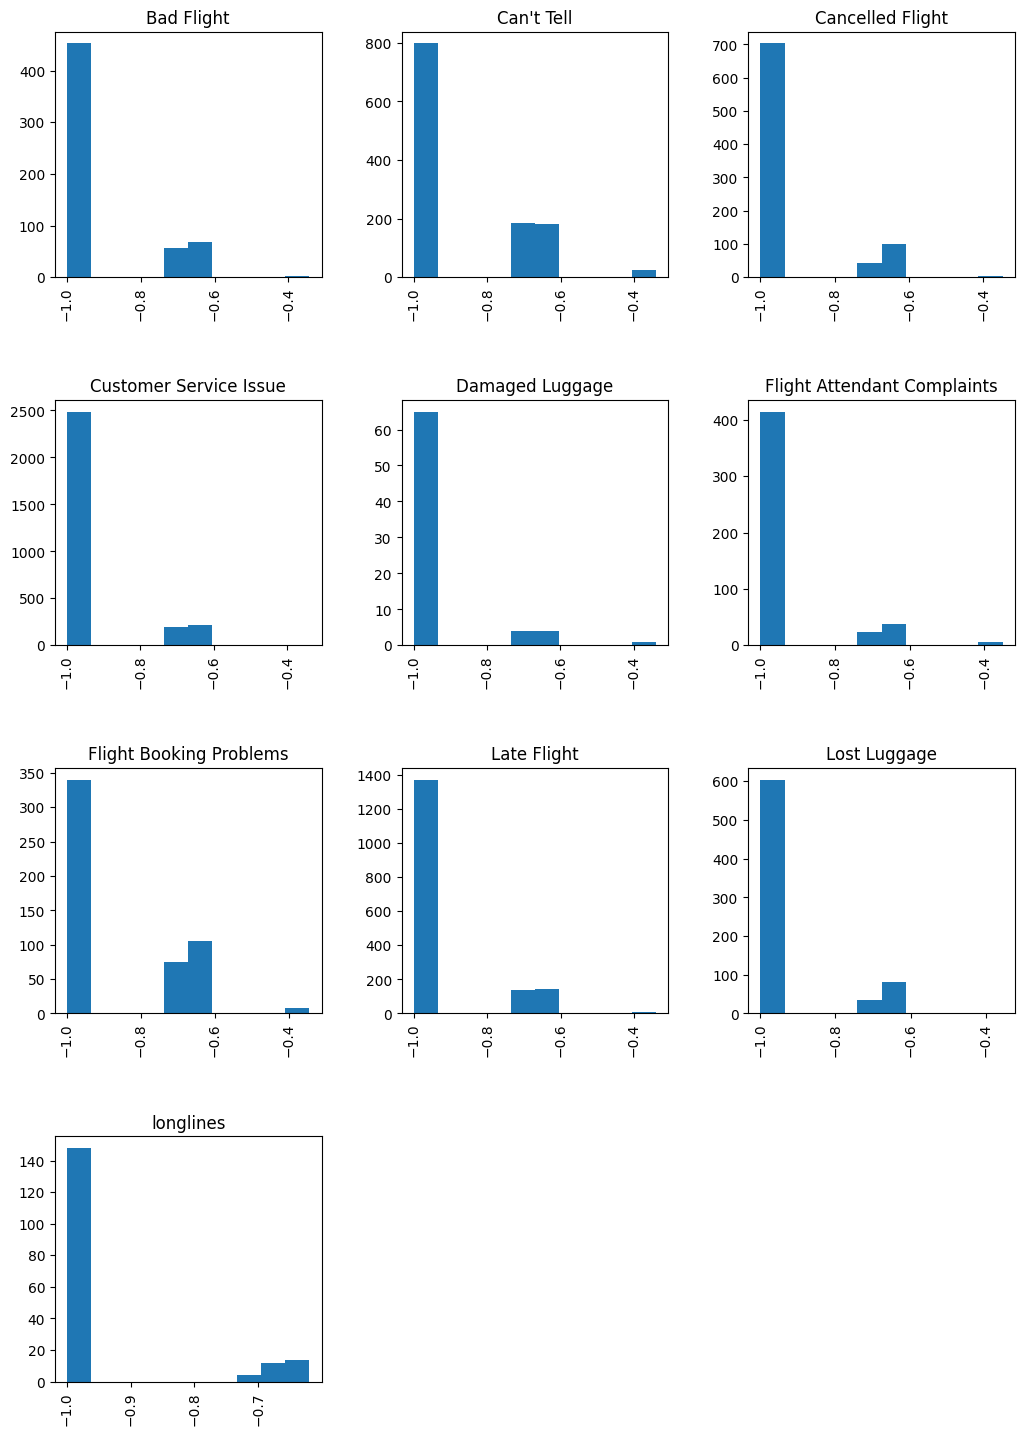

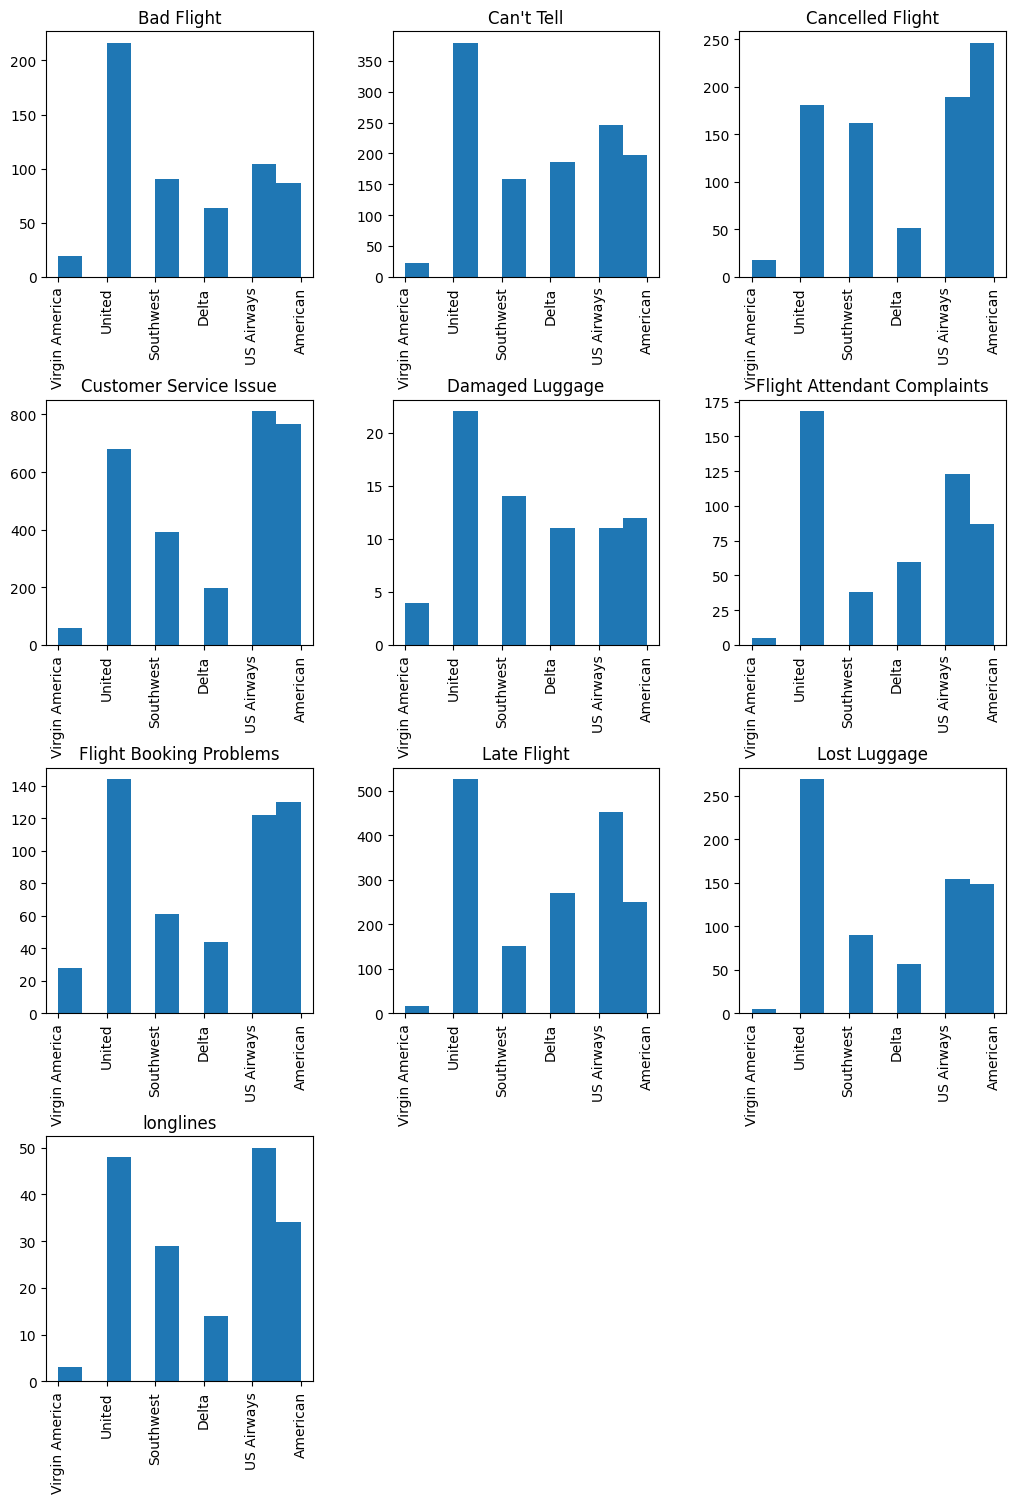

In [ ]:
# look at Negative Reason distribution
data_neg = tweets_df[tweets_df['numeric_sentiment'] < 0]
data_neg.hist(column ='weighted_sentiment', by='negativereason',figsize=(12,18))
data_neg.hist(column ='airline', by='negativereason',figsize=(12,18))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5462
negativereason_confidence        4118
airline                             0
airline_sentiment_gold          14600
name                                0
negativereason_gold             14608
retweet_count                       0
text                                0
tweet_coord                     13621
tweet_created                       0
tweet_location                   4733
user_timezone                    4820
numeric_sentiment                   0
weighted_sentiment                  0
dtype: int64


<Axes: xlabel='airline_sentiment', ylabel='count'>

Text(0.5, 1.0, 'Sentiment Distribution')

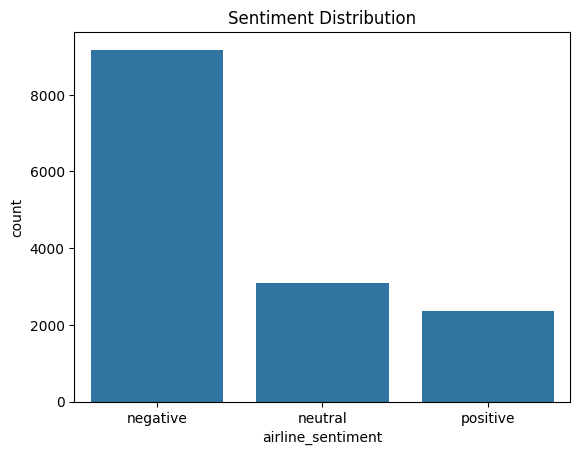

<Axes: xlabel='airline', ylabel='count'>

Text(0.5, 1.0, 'Sentiment Distribution by Airline')

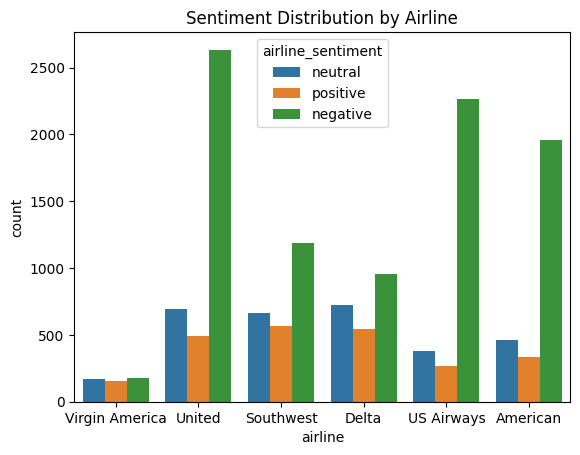

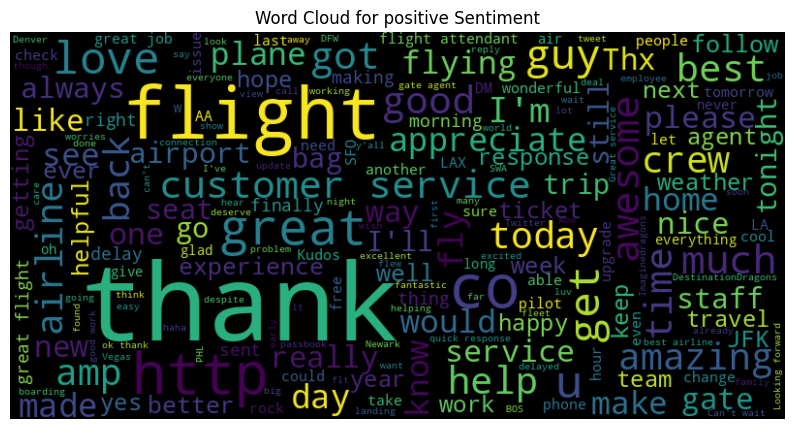

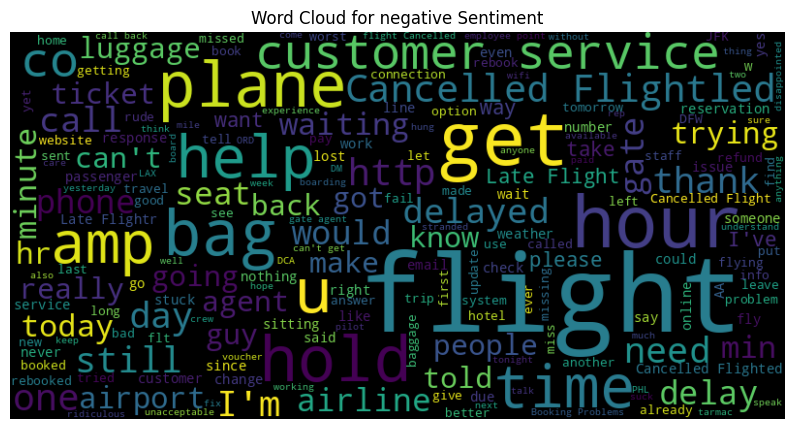

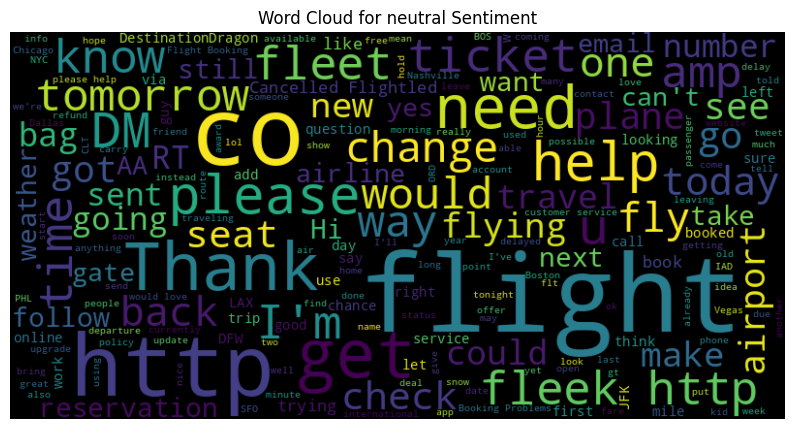

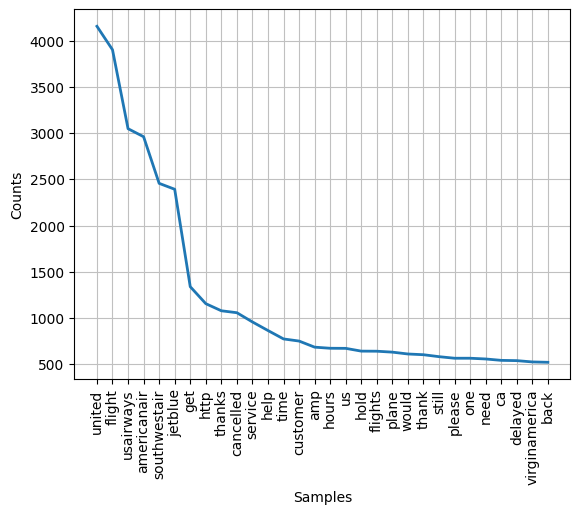

<Axes: xlabel='Samples', ylabel='Counts'>

In [ ]:
#create visuals

nltk.download('stopwords')
nltk.download('punkt')

# Check for missing values
print(tweets_df.isnull().sum())

# Explore sentiment distribution
sns.countplot(x='airline_sentiment', data=tweets_df, order=tweets_df['airline_sentiment'].value_counts().index)
plt.title('Sentiment Distribution')
plt.show()

# Explore sentiment distribution for each airline
sns.countplot(x='airline', hue='airline_sentiment', data=tweets_df)
plt.title('Sentiment Distribution by Airline')
plt.show()

# Word cloud for positive, negative, and neutral sentiments
company_names = ['Virgin America', 'United', 'Southwest', 'Delta', 'US Airways', 'American', 'JetBlue',
                'Southwest Air', 'SouthwestAir', 'VirginAmerica', 'AmericanAir', 'USAir', 'USAirways']
stop_words = set(stopwords.words('english') + company_names)

def plot_wordcloud(sentiment):
    words = ' '.join(tweets_df[tweets_df['airline_sentiment'] == sentiment]['text'])
    wordcloud = WordCloud(width=800, height=400, stopwords = stop_words, random_state=21, max_font_size=110).generate(words)
    plt.figure(figsize=(10, 7))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    plt.title(f'Word Cloud for {sentiment} Sentiment')
    plt.show()

plot_wordcloud('positive')
plot_wordcloud('negative')
plot_wordcloud('neutral')

# Tokenize and analyze word frequencies

def process_text(text):
    words = word_tokenize(text)
    words = [word.lower() for word in words if word.isalpha() and word.lower() not in stop_words]
    return words

tweets_df['processed_text'] = tweets_df['text'].apply(process_text)

# Calculate and plot word frequencies
all_words = [word for sublist in tweets_df['processed_text'] for word in sublist]
freq_dist = FreqDist(all_words)
freq_dist.plot(30, cumulative=False)


## Cleaning the Data

In [ ]:
# We note that the majority of airline_sentiment_gold is empty. However, non-null values may be validated (of a "gold standard").

diffs = tweets_df[tweets_df['airline_sentiment_gold'].notnull()]
diffs = (diffs['airline_sentiment'] != diffs['airline_sentiment_gold']).any()

print(diffs)

## There are no differences between airline_sentiment and airline_sentiment_gold. We remove the latter column.
tweets_df.drop(columns=['airline_sentiment_gold'], inplace=True)

False


In [ ]:
# However, there are differences between those of negativereason and negativereason_gold.

# If confidence level in airline_sentiment_confidence is higher on average we'd suspect that negativereason_gold values are validated as compared with negativereason.
sentiment_mean = tweets_df.groupby('negativereason')['airline_sentiment_confidence'].mean()
gold_sent_mean = tweets_df.groupby('negativereason_gold')['airline_sentiment_confidence'].mean()

print(f"Mean of confidence for negativereason:\n{sentiment_mean}")
print(f"\nMean of confidence for negativereason_gold:\n{gold_sent_mean}")

## Since negativereason_gold has a higher mean confidence level in the value of the sentiment, we impute gold values over negativereason values.
tweets_df['imputed_neg_reason'] = tweets_df['negativereason_gold'].fillna(tweets_df['negativereason'])

check_df = tweets_df[(tweets_df['negativereason_gold'].notnull()) & (tweets_df['negativereason_gold'] != tweets_df['negativereason'])]
check_df = check_df[['negativereason', 'negativereason_gold', 'text']]
check_df

## A spot check confirms negativereason_gold offers more adequate information to the Tweet.

Mean of confidence for negativereason:
negativereason
Bad Flight                     0.925816
Can't Tell                     0.885067
Cancelled Flight               0.941773
Customer Service Issue         0.951616
Damaged Luggage                0.955727
Flight Attendant Complaints    0.951697
Flight Booking Problems        0.876460
Late Flight                    0.940308
Lost Luggage                   0.944268
longlines                      0.943487
Name: airline_sentiment_confidence, dtype: float64

Mean of confidence for negativereason_gold:
negativereason_gold
Bad Flight                                  0.965800
Can't Tell                                  0.913100
Cancelled Flight                            1.000000
Cancelled Flight\nCustomer Service Issue    0.924850
Customer Service Issue                      0.990667
Customer Service Issue\nCan't Tell          0.799100
Customer Service Issue\nLost Luggage        1.000000
Flight Attendant Complaints                 0.955300
Late F

negativereason                       negativereason_gold  \
1286              Late Flight  Late Flight\nFlight Attendant Complaints   
2017              Late Flight                 Late Flight\nLost Luggage   
3149   Customer Service Issue  Cancelled Flight\nCustomer Service Issue   
6530   Customer Service Issue  Cancelled Flight\nCustomer Service Issue   
8536             Lost Luggage             Lost Luggage\nDamaged Luggage   
12025        Cancelled Flight             Late Flight\nCancelled Flight   
12034            Lost Luggage      Customer Service Issue\nLost Luggage   
12038               longlines                    Customer Service Issue   
12039              Can't Tell        Customer Service Issue\nCan't Tell   

                                                    text  
1286   @united I'm aware of the flight details, thank...  
2017   @united flighted delayed for hours. 10pm arriv...  
3149   @united rebooked 24 hours after original fligh...  
6530   @SouthwestAir I never got a Cancelled Flightla...  
8536   @JetBlue I am heading to JFK now just on princ...  
12025  @AmericanAir over the last year 50% of my flig...  
12034  @AmericanAir you need to work harder on the di...  
12038  @DeltaAssist now at 57 minutes waiting on Silv...  
12039  @DeltaAssist what I have to say is more than 1...

## Feature Engineering

In [ ]:
# Cleaning user_timezone values in stages. tweet_location not as useful (e.g., one value is 'Earth' and that occurs in Eastern Time.)

# Clean timezone column
tweets_df['clean_timezone'] = tweets_df['user_timezone'].where(tweets_df['user_timezone'].str.contains('Time \('))

# Fill NaN values in the original column
tweets_df['user_timezone'].fillna('N/A', inplace=True)

# Unclean timezone column
tweets_df['unclean_timezone'] = tweets_df['user_timezone'].where(~tweets_df['clean_timezone'].notna())

## Code leaves in unclean_timezone column. We could delete the above line and simply use clean_timezone where timezone is known and clean.

In [ ]:
# Convert 'tweet_created' column to datetime dtype
tweets_df['tweet_created'] = pd.to_datetime(tweets_df['tweet_created'])

# Extract day of the month
tweets_df['tweet_day'] = tweets_df['tweet_created'].dt.day

# Extract time of day
tweets_df['time_of_day'] = pd.cut(
    tweets_df['tweet_created'].dt.hour,
    bins=[0, 6, 12, 18, 24],
    labels=['Night', 'Morning', 'Afternoon', 'Evening'],
    include_lowest=True
)


### Pull Only Data Columns of Interest

In [ ]:
#clean up data set
data_pre_process=tweets_df[['text','numeric_sentiment', 'weighted_sentiment','airline']]

### Initial Cleaning of Text Column and Prepare Data for Thorough Cleaning

In [ ]:
#clean the text column for random forest modelling to identify key word counts
from bs4 import BeautifulSoup
import re
import nltk
# nltk.download()
from nltk.corpus import stopwords # Import the stop word list
nltk.download('stopwords')

data_size = (data_pre_process['text'].size)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Cleaning the Data Using Beautiful Soup

In [ ]:
#function to clean text usint Beautiful Soup
def clean_text_data(data_point, data_size):
    review_soup = BeautifulSoup(data_point)
    review_text = review_soup.get_text()
    review_letters_only = re.sub("[^a-zA-Z]", " ", review_text)
    review_lower_case = review_letters_only.lower()
    review_words = review_lower_case.split()
    stop_words = stopwords.words("english")
    meaningful_words = [x for x in review_words if x not in stop_words]

    if( (i)%2000 == 0 ):
        print("Cleaned %d of %d data (%d %%)." % ( i, data_size, ((i)/data_size)*100))

    return( " ".join( meaningful_words))

for i in range(data_size):
    data_pre_process["text"][i] = clean_text_data(data_pre_process["text"][i], data_size)
print("Cleaning training completed!")

<ipython-input-15-85e9262fa24a>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pre_process["text"][i] = clean_text_data(data_pre_process["text"][i], data_size)
<ipython-input-15-85e9262fa24a>:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  review_soup = BeautifulSoup(data_point)


Cleaned 0 of 14640 data (0 %).
Cleaned 2000 of 14640 data (13 %).
Cleaned 4000 of 14640 data (27 %).
Cleaned 6000 of 14640 data (40 %).
Cleaned 8000 of 14640 data (54 %).
Cleaned 10000 of 14640 data (68 %).
Cleaned 12000 of 14640 data (81 %).
Cleaned 14000 of 14640 data (95 %).
Cleaning training completed!


### Executing a Random Forest Model Without Fitting to Learn Top Phrases and Number of Occurences for Each

(11712, 141166)
(2928, 141166)


<ipython-input-16-8eb1748bbf50>:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  graph.set_xticklabels(


[Text(0, 0, 'customer service'),
 Text(1, 0, 'cancelled flightled'),
 Text(2, 0, 'late flight'),
 Text(3, 0, 'flight cancelled'),
 Text(4, 0, 'cancelled flighted'),
 Text(5, 0, 'fleet fleek'),
 Text(6, 0, 'booking problems'),
 Text(7, 0, 'flight cancelled flightled'),
 Text(8, 0, 'late flightr'),
 Text(9, 0, 'cancelled flight')]

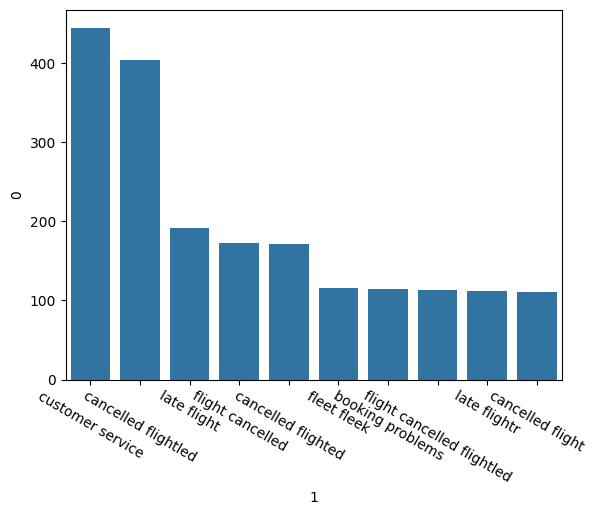

In [ ]:
vectorizer = CountVectorizer(analyzer = "word",   \
                             ngram_range= (2,3),   \
                             tokenizer = None,    \
                             preprocessor = None, \
                             stop_words = ['united','usairways','americanair','southwestair','jetblue','http','http co','co','virginamerica'])


X_train, X_cv, Y_train, Y_cv = train_test_split(data_pre_process["text"], data_pre_process["numeric_sentiment"], test_size = 0.2, random_state=42)

X_train = vectorizer.fit_transform(X_train)
X_train = X_train.toarray()
print(X_train.shape)

X_cv = vectorizer.transform(X_cv)
X_cv = X_cv.toarray()
print(X_cv.shape)

vocab = vectorizer.get_feature_names_out()
distribution = np.sum(X_train, axis=0)

#for tag, count in zip(distribution[:100],vocab[:100]):
#    print(count, tag)

zipped = zip (distribution,vocab)
zipped = list(zipped)
zipped.sort(reverse=True)
zip_top = zipped[:10]
zip_top_df = pd.DataFrame(zip_top)
#zip_top_df.head()
graph = sns.barplot(zip_top_df,x=zip_top_df[1],y=zip_top_df[0])
graph.set_xticklabels(
    labels=zip_top_df[1], rotation=-30)
plt.show()

## Bag of Words

In [ ]:
tweets_df1 = tweets_df.copy()
tweets_df1['text'] = tweets_df1['text'].astype(str)

In [ ]:
stop_words = set(stopwords.words('english'))
stop_words.remove('not') #need 'not' as a negative identifier in tweets

string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
#clean Tweet text
ps = PorterStemmer()

tweet_list = []

for i in range(0, 14640):
    tweet = re.sub('@[^\s]+','', tweets_df1['text'][i])
    tweet = re.sub('http[^\s]+','', tweet)
    tweet = re.sub('['+string.punctuation+']', '', tweet)
    tweet = tweet.lower()
    tweet = tweet.split()
    tweet = [ps.stem(word) for word in tweet if not word in stop_words]
    tweet = ' '.join(tweet)
    tweet_list.append(tweet)

In [ ]:
#remove emojis
def remove_emoji(text):
    emojis = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)

    text = re.sub(emojis,'',text)
    return text

tweet_list = list(map(remove_emoji, tweet_list))

In [ ]:
len(tweet_list)
tweet_list[1:5]

14640

['plu youv ad commerci experi tacki',
 'didnt today must mean need take anoth trip',
 'realli aggress blast obnoxi entertain guest face amp littl recours',
 'realli big bad thing']

In [ ]:
#find unique words for count vectorizor
text = ' '.join(tweet_list)
words = text.split()
unique_words = set(words)
print(len(unique_words))

#look at word counts
word_count = Counter(words)
sorted_word_count = sorted(word_count.items(), key = lambda x: x[1], reverse=True)
for word, count in sorted_word_count:
    print(f'{word}: {count}')

#find all words that occur at least 5 times
count_mult_words = sum(1 for word, count in sorted_word_count if count >= 5)
print(count_mult_words)

Streaming output truncated to the last 5000 lines.
ridic: 1
paycheck: 1
thingunit: 1
crackersnabisco: 1
pepperidg: 1
farm: 1
2daysofhel: 1
exitrow: 1
rj145: 1
lta: 1
answerthi: 1
whack: 1
circul: 1
burningman: 1
mkwlkr: 1
b737900: 1
9may5sep: 1
ua6465: 1
lostyou: 1
63446373: 1
sfodfw: 1
1576: 1
sfoord: 1
disappointedunit: 1
waspaid: 1
ua6255: 1
winnipeg: 1
ua1059: 1
tightconnect: 1
coltsmissingbag: 1
lightyear: 1
frighten: 1
1person: 1
namesdalla: 1
borderlin: 1
letsworktogeth: 1
dope: 1
staffcust: 1
lgaord: 1
711: 1
unempathet: 1
fulldont: 1
pri: 1
opsec: 1
leisur: 1
master: 1
companyi: 1
4411: 1
aircargo: 1
bcn: 1
ltltltltlt: 1
whatsoev: 1
ltltltltltlt: 1
correspond: 1
2600: 1
anticonsum: 1
welfar: 1
turquois: 1
ua1121: 1
upc: 1
swimsuit: 1
179: 1
324: 1
unitedwithivi: 1
falseadvertis: 1
ua1127: 1
addr: 1
signin: 1
dxb: 1
sime: 1
noapolog: 1
restructur: 1
brotha: 1
multipli: 1
teleport: 1
ua514: 1
rtbgtiah: 1
cigarett: 1
prohibit: 1
bagyet: 1
stonewal: 1
ua3710: 1
3710: 1
collid: 1
o

### Count Vectorizer

In [ ]:
cv = CountVectorizer(max_features = 2471)
cv.fit(tweet_list)

CountVectorizer(max_features=2471)

In [ ]:
#create bag of words
bow = cv.transform(tweet_list)
bow.shape

#create bag of words dataframe
bow_df = pd.DataFrame(bow.toarray())
bow_df.columns = cv.get_feature_names_out()
bow_df.head()

(14640, 2471)

10  100  1000  10000  1024  1030  105  1051  10pm  11  1130  1130pm  12  \
0   0    0     0      0     0     0    0     0     0   0     0       0   0   
1   0    0     0      0     0     0    0     0     0   0     0       0   0   
2   0    0     0      0     0     0    0     0     0   0     0       0   0   
3   0    0     0      0     0     0    0     0     0   0     0       0   0   
4   0    0     0      0     0     0    0     0     0   0     0       0   0   

   1200  1230  13  130  136  13th  14  140  15  150  15min  15th  16  17  18  \
0     0     0   0    0    0     0   0    0   0    0      0     0   0   0   0   
1     0     0   0    0    0     0   0    0   0    0      0     0   0   0   0   
2     0     0   0    0    0     0   0    0   0    0      0     0   0   0   0   
3     0     0   0    0    0     0   0    0   0    0      0     0   0   0   0   
4     0     0   0    0    0     0   0    0   0    0      0     0   0   0   0   

   180  1800  19  1hr  1k  1pm  1st  1way  20  200  2000  2014  2015  20min  \
0    0     0   0    0   0    0    0     0   0    0     0     0     0      0   
1    0     0   0    0   0    0    0     0   0    0     0     0     0      0   
2    0     0   0    0   0    0    0     0   0    0     0     0     0      0   
3    0     0   0    0   0    0    0     0   0    0     0     0     0      0   
4    0     0   0    0   0    0    0     0   0    0     0     0     0      0   

   21  215  219  22  221  222  223  224  228  23  24  24hr  24th  25  250  26  \
0   0    0    0   0    0    0    0    0    0   0   0     0     0   0    0   0   
1   0    0    0   0    0    0    0    0    0   0   0     0     0   0    0   0   
2   0    0    0   0    0    0    0    0    0   0   0     0     0   0    0   0   
3   0    0    0   0    0    0    0    0    0   0   0     0     0   0    0   0   
4   0    0    0   0    0    0    0    0    0   0   0     0     0   0    0   0   

   27  28  2day  2hr  2nd  2pm  2x  30  300  3056  30min  32  33  330  34  35  \
0   0   0     0    0    0    0   0   0    0     0      0   0   0    0   0   0   
1   0   0     0    0    0    0   0   0    0     0      0   0   0    0   0   0   
2   0   0     0    0    0    0   0   0    0     0      0   0   0    0   0   0   
3   0   0     0    0    0    0   0   0    0     0      0   0   0    0   0   0   
4   0   0     0    0    0    0   0   0    0     0      0   0   0    0   0   0   

   36  386  39  3am  3d  3hr  3pm  3rd  3x  40  400  40min  42  44  445  45  \
0   0    0   0    0   0    0    0    0   0   0    0      0   0   0    0   0   
1   0    0   0    0   0    0    0    0   0   0    0      0   0   0    0   0   
2   0    0   0    0   0    0    0    0   0   0    0      0   0   0    0   0   
3   0    0   0    0   0    0    0    0   0   0    0      0   0   0    0   0   
4   0    0   0    0   0    0    0    0   0   0    0      0   0   0    0   0   

   450  4567  45min  46  475  48  4hr  4pm  4th  50  500  50k  530  5350  55  \
0    0     0      0   0    0   0    0    0    0   0    0    0    0     0   0   
1    0     0      0   0    0   0    0    0    0   0    0    0    0     0   0   
2    0     0      0   0    0   0    0    0    0   0    0    0    0     0   0   
3    0     0      0   0    0   0    0    0    0   0    0    0    0     0   0   
4    0     0      0   0    0   0    0    0    0   0    0    0    0     0   0   

   550  56  59  5hr  5pm  5th  60  600  615  630  65  669  68  699  6am  6pm  \
0    0   0   0    0    0    0   0    0    0    0   0    0   0    0    0    0   
1    0   0   0    0    0    0   0    0    0    0   0    0   0    0    0    0   
2    0   0   0    0    0    0   0    0    0    0   0    0   0    0    0    0   
3    0   0   0    0    0    0   0    0    0    0   0    0   0    0    0    0   
4    0   0   0    0    0    0   0    0    0    0   0    0   0    0    0    0   

   70  700  703  710  719  72  728  728feb  730  747  75  777  787  79  7am  \
0   0    0    0    0    0   0    0       0    0    0   0    0    0   0    0   
1   0    

## Join Dataframes

In [ ]:
tweets_df2 = pd.concat([tweets_df1, bow_df.set_axis(tweets_df1.index)], axis=1)
tweets_df2.info()
tweets_df2.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Columns: 2493 entries, tweet_id to zone
dtypes: category(1), datetime64[ns, pytz.FixedOffset(-480)](1), float64(3), int64(2475), object(13)
memory usage: 278.4+ MB


tweet_id airline_sentiment  airline_sentiment_confidence  \
0  570306133677760513           neutral                        1.0000   
1  570301130888122368          positive                        0.3486   
2  570301083672813571           neutral                        0.6837   
3  570301031407624196          negative                        1.0000   
4  570300817074462722          negative                        1.0000   

  negativereason  negativereason_confidence         airline        name  \
0            NaN                        NaN  Virgin America     cairdin   
1            NaN                     0.0000  Virgin America    jnardino   
2            NaN                        NaN  Virgin America  yvonnalynn   
3     Bad Flight                     0.7033  Virgin America    jnardino   
4     Can't Tell                     1.0000  Virgin America    jnardino   

  negativereason_gold  retweet_count  \
0                 NaN              0   
1                 NaN              0   
2                 NaN              0   
3                 NaN              0   
4                 NaN              0   

                                                text tweet_coord  \
0                @VirginAmerica What @dhepburn said.         NaN   
1  @VirginAmerica plus you've added commercials t...         NaN   
2  @VirginAmerica I didn't today... Must mean I n...         NaN   
3  @VirginAmerica it's really aggressive to blast...         NaN   
4  @VirginAmerica and it's a really big bad thing...         NaN   

              tweet_created tweet_location               user_timezone  \
0 2015-02-24 11:35:52-08:00            NaN  Eastern Time (US & Canada)   
1 2015-02-24 11:15:59-08:00            NaN  Pacific Time (US & Canada)   
2 2015-02-24 11:15:48-08:00      Lets Play  Central Time (US & Canada)   
3 2015-02-24 11:15:36-08:00            NaN  Pacific Time (US & Canada)   
4 2015-02-24 11:14:45-08:00            NaN  Pacific Time (US & Canada)   

   numeric_sentiment  weighted_sentiment  \
0                  0              0.0000   
1                  1              0.3486   
2                  0              0.0000   
3                 -1             -1.0000   
4                 -1             -1.0000   

                                      processed_text imputed_neg_reason  \
0                    [virginamerica, dhepburn, said]                NaN   
1  [virginamerica, plus, added, commercials, expe...                NaN   
2  [virginamerica, today, must, mean, need, take,...                NaN   
3  [virginamerica, really, aggressive, blast, obn...         Bad Flight   
4           [virginamerica, really, big, bad, thing]         Can't Tell   

               clean_timezone unclean_timezone  tweet_day time_of_day  10  \
0  Eastern Time (US & Canada)              NaN         24     Morning   0   
1  Pacific Time (US & Canada)              NaN         24     Morning   0   
2  Central Time (US & Canada)              NaN         24     Morning   0   
3  Pacific Time (US & Canada)              NaN         24     Morning   0   
4  Pacific Time (US & Canada)              NaN         24     Morning   0   

   100  1000  10000  1024  1030  105  1051  10pm  11  1130  1130pm  12  1200  \
0    0     0      0     0     0    0     0     0   0     0       0   0     0   
1    0     0      0     0     0    0     0     0   0     0       0   0     0   
2    0     0      0     0     0    0     0     0   0     0       0   0     0   
3    0     0      0     0     0    0     0     0   0     0       0   0     0   
4    0     0      0     0     0    0     0     0   0     0       0   0     0   

   1230  13  130  136  13th  14  140  15  150  15min  15th  16  17  18  180  \
0     0   0    0    0     0   0    0   0    0      0     0   0   0   0    0   
1     0   0    0    0     0   0    0   0    0      0     0   0   0   0    0   
2     0   0    0    0     0   0    0   0    0      0     0   0   0   0    0   
3     0   0    0    0     0   0    0   0    0      0

### Drop Irrelevant Columns

In [ ]:
tweets_df3 = tweets_df2.copy()

In [ ]:
columns = ['airline_sentiment', 'airline_sentiment_confidence', 'negativereason',
           'negativereason_confidence', 'name', 'negativereason_gold', 'text', 'tweet_coord',
           'tweet_created', 'tweet_location', 'user_timezone', 'weighted_sentiment', 'processed_text',
          'unclean_timezone']

tweets_df3 = tweets_df3.drop(columns, axis = 1)
tweets_df3.head()

tweet_id         airline  retweet_count  numeric_sentiment  \
0  570306133677760513  Virgin America              0                  0   
1  570301130888122368  Virgin America              0                  1   
2  570301083672813571  Virgin America              0                  0   
3  570301031407624196  Virgin America              0                 -1   
4  570300817074462722  Virgin America              0                 -1   

  imputed_neg_reason              clean_timezone  tweet_day time_of_day  10  \
0                NaN  Eastern Time (US & Canada)         24     Morning   0   
1                NaN  Pacific Time (US & Canada)         24     Morning   0   
2                NaN  Central Time (US & Canada)         24     Morning   0   
3         Bad Flight  Pacific Time (US & Canada)         24     Morning   0   
4         Can't Tell  Pacific Time (US & Canada)         24     Morning   0   

   100  1000  10000  1024  1030  105  1051  10pm  11  1130  1130pm  12  1200  \
0    0     0      0     0     0    0     0     0   0     0       0   0     0   
1    0     0      0     0     0    0     0     0   0     0       0   0     0   
2    0     0      0     0     0    0     0     0   0     0       0   0     0   
3    0     0      0     0     0    0     0     0   0     0       0   0     0   
4    0     0      0     0     0    0     0     0   0     0       0   0     0   

   1230  13  130  136  13th  14  140  15  150  15min  15th  16  17  18  180  \
0     0   0    0    0     0   0    0   0    0      0     0   0   0   0    0   
1     0   0    0    0     0   0    0   0    0      0     0   0   0   0    0   
2     0   0    0    0     0   0    0   0    0      0     0   0   0   0    0   
3     0   0    0    0     0   0    0   0    0      0     0   0   0   0    0   
4     0   0    0    0     0   0    0   0    0      0     0   0   0   0    0   

   1800  19  1hr  1k  1pm  1st  1way  20  200  2000  2014  2015  20min  21  \
0     0   0    0   0    0    0     0   0    0     0     0     0      0   0   
1     0   0    0   0    0    0     0   0    0     0     0     0      0   0   
2     0   0    0   0    0    0     0   0    0     0     0     0      0   0   
3     0   0    0   0    0    0     0   0    0     0     0     0      0   0   
4     0   0    0   0    0    0     0   0    0     0     0     0      0   0   

   215  219  22  221  222  223  224  228  23  24  24hr  24th  25  250  26  27  \
0    0    0   0    0    0    0    0    0   0   0     0     0   0    0   0   0   
1    0    0   0    0    0    0    0    0   0   0     0     0   0    0   0   0   
2    0    0   0    0    0    0    0    0   0   0     0     0   0    0   0   0   
3    0    0   0    0    0    0    0    0   0   0     0     0   0    0   0   0   
4    0    0   0    0    0    0    0    0   0   0     0     0   0    0   0   0   

   28  2day  2hr  2nd  2pm  2x  30  300  3056  30min  32  33  330  34  35  36  \
0   0     0    0    0    0   0   0    0     0      0   0   0    0   0   0   0   
1   0     0    0    0    0   0   0    0     0      0   0   0    0   0   0   0   
2   0     0    0    0    0   0   0    0     0      0   0   0    0   0   0   0   
3   0     0    0    0    0   0   0    0     0      0   0   0    0   0   0   0   
4   0     0    0    0    0   0   0    0     0      0   0   0    0   0   0   0   

   386  39  3am  3d  3hr  3pm  3rd  3x  40  400  40min  42  44  445  45  450  \
0    0   0    0   0    0    0    0   0   0    0      0   0   0    0   0    0   
1    0   0    0   0    0    0    0   0   0    0      0   0   0    0   0    0   
2    0   0    0   0    0    0    0   0   0    0      0   0   0    0   0    0   
3    0   0    0   0    0    0    0   0   0    0      0   0   0    0   0    0   
4    0   0    0   0    0    0    0   0   0    0      0   0   0    0   0    0   

   4567  45min  46  475  48  4hr  4pm  4th  50  500  50k  530  5350  55  550  \
0     0      0   0    0   0    0    0    0   0    0    0    0     0   0    0   
1     0      0   0    0   0    0    0    0   0 

## Encoding

In [ ]:
#encode categorical variables

# Converting type of columns to category
tweets_df3['airline'] = tweets_df3['airline'].astype('category')
tweets_df3['imputed_neg_reason'] = tweets_df3['imputed_neg_reason'].astype('category')
tweets_df3['clean_timezone'] = tweets_df3['clean_timezone'].astype('category')
tweets_df3['time_of_day'] = tweets_df3['time_of_day'].astype('category')

# Assigning numerical values and storing it in another columns
tweets_df3['airline_new'] = tweets_df3['airline'].cat.codes
tweets_df3['imputed_neg_reason_new'] = tweets_df3['imputed_neg_reason'].cat.codes
tweets_df3['clean_timezone_new'] = tweets_df3['clean_timezone'].cat.codes
tweets_df3['time_of_day_new'] = tweets_df3['time_of_day'].cat.codes

# one hot encoder
enc = OneHotEncoder()

# Passing encoded columns
enc_data = pd.DataFrame(enc.fit_transform(
    tweets_df3[['airline_new', 'imputed_neg_reason_new', 'clean_timezone_new', 'time_of_day_new']]).toarray())

# Merge with main
tweets_df4 = tweets_df3.join(enc_data)
tweets_df4.columns = tweets_df4.columns.astype(str)
tweets_df4 = tweets_df4.drop(['airline', 'imputed_neg_reason', 'clean_timezone', 'time_of_day'], axis = 1)

tweets_df4.head()
tweets_df4.info()

tweet_id  retweet_count  numeric_sentiment  tweet_day  10  100  \
0  570306133677760513              0                  0         24   0    0   
1  570301130888122368              0                  1         24   0    0   
2  570301083672813571              0                  0         24   0    0   
3  570301031407624196              0                 -1         24   0    0   
4  570300817074462722              0                 -1         24   0    0   

   1000  10000  1024  1030  105  1051  10pm  11  1130  1130pm  12  1200  1230  \
0     0      0     0     0    0     0     0   0     0       0   0     0     0   
1     0      0     0     0    0     0     0   0     0       0   0     0     0   
2     0      0     0     0    0     0     0   0     0       0   0     0     0   
3     0      0     0     0    0     0     0   0     0       0   0     0     0   
4     0      0     0     0    0     0     0   0     0       0   0     0     0   

   13  130  136  13th  14  140  15  150  15min  15th  16  17  18  180  1800  \
0   0    0    0     0   0    0   0    0      0     0   0   0   0    0     0   
1   0    0    0     0   0    0   0    0      0     0   0   0   0    0     0   
2   0    0    0     0   0    0   0    0      0     0   0   0   0    0     0   
3   0    0    0     0   0    0   0    0      0     0   0   0   0    0     0   
4   0    0    0     0   0    0   0    0      0     0   0   0   0    0     0   

   19  1hr  1k  1pm  1st  1way  20  200  2000  2014  2015  20min  21  215  \
0   0    0   0    0    0     0   0    0     0     0     0      0   0    0   
1   0    0   0    0    0     0   0    0     0     0     0      0   0    0   
2   0    0   0    0    0     0   0    0     0     0     0      0   0    0   
3   0    0   0    0    0     0   0    0     0     0     0      0   0    0   
4   0    0   0    0    0     0   0    0     0     0     0      0   0    0   

   219  22  221  222  223  224  228  23  24  24hr  24th  25  250  26  27  28  \
0    0   0    0    0    0    0    0   0   0     0     0   0    0   0   0   0   
1    0   0    0    0    0    0    0   0   0     0     0   0    0   0   0   0   
2    0   0    0    0    0    0    0   0   0     0     0   0    0   0   0   0   
3    0   0    0    0    0    0    0   0   0     0     0   0    0   0   0   0   
4    0   0    0    0    0    0    0   0   0     0     0   0    0   0   0   0   

   2day  2hr  2nd  2pm  2x  30  300  3056  30min  32  33  330  34  35  36  \
0     0    0    0    0   0   0    0     0      0   0   0    0   0   0   0   
1     0    0    0    0   0   0    0     0      0   0   0    0   0   0   0   
2     0    0    0    0   0   0    0     0      0   0   0    0   0   0   0   
3     0    0    0    0   0   0    0     0      0   0   0    0   0   0   0   
4     0    0    0    0   0   0    0     0      0   0   0    0   0   0   0   

   386  39  3am  3d  3hr  3pm  3rd  3x  40  400  40min  42  44  445  45  450  \
0    0   0    0   0    0    0    0   0   0    0      0   0   0    0   0    0   
1    0   0    0   0    0    0    0   0   0    0      0   0   0    0   0    0   
2    0   0    0   0    0    0    0   0   0    0      0   0   0    0   0    0   
3    0   0    0   0    0    0    0   0   0    0      0   0   0    0   0    0   
4    0   0    0   0    0    0    0   0   0    0      0   0   0    0   0    0   

   4567  45min  46  475  48  4hr  4pm  4th  50  500  50k  530  5350  55  550  \
0     0      0   0    0   0    0    0    0   0    0    0    0     0   0    0   
1     0      0   0    0   0    0    0    0   0    0    0    0     0   0    0   
2     0      0   0    0   0    0    0    0   0    0    0    0     0   0    0   
3     0      0   0    0   0    0    0    0   0    0    0    0     0   0    0   
4     0      0   0    0   0    0    0    0   0    0    0    0     0   0    0   

   56  59  5hr  5pm  5th  60  600  615  630  65  669  68  699  6am  6pm  70  \
0   0   0    0    0    0   0    0    0    0   0    0   0    0    0    0   0   
1   0   0    0    0    0   0    0    0    0   0  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Columns: 2511 entries, tweet_id to 33
dtypes: float64(34), int64(2473), int8(4)
memory usage: 280.1 MB


## Create Models

In [ ]:
#split train and test datasets 80/20 split
train_df, rest_df = train_test_split(tweets_df4, train_size=0.8, shuffle=False)

#split validation and test data 10/10 split
val_df, test_df = train_test_split(rest_df, test_size = 0.5, shuffle = False)

In [ ]:
#get targets
train_target = train_df['numeric_sentiment']
train_tweet_ids = train_df['tweet_id']
train_df = train_df.drop(['numeric_sentiment', 'tweet_id'], axis = 1)

val_target = val_df['numeric_sentiment']
val_tweet_ids = val_df['tweet_id']
val_df = val_df.drop(['numeric_sentiment', 'tweet_id'], axis = 1)

test_target = test_df['numeric_sentiment']
test_tweet_ids = test_df['tweet_id']
test_df = test_df.drop(['numeric_sentiment', 'tweet_id'], axis = 1)

In [ ]:
train_df.head()

retweet_count  tweet_day  10  100  1000  10000  1024  1030  105  1051  \
0              0         24   0    0     0      0     0     0    0     0   
1              0         24   0    0     0      0     0     0    0     0   
2              0         24   0    0     0      0     0     0    0     0   
3              0         24   0    0     0      0     0     0    0     0   
4              0         24   0    0     0      0     0     0    0     0   

   10pm  11  1130  1130pm  12  1200  1230  13  130  136  13th  14  140  15  \
0     0   0     0       0   0     0     0   0    0    0     0   0    0   0   
1     0   0     0       0   0     0     0   0    0    0     0   0    0   0   
2     0   0     0       0   0     0     0   0    0    0     0   0    0   0   
3     0   0     0       0   0     0     0   0    0    0     0   0    0   0   
4     0   0     0       0   0     0     0   0    0    0     0   0    0   0   

   150  15min  15th  16  17  18  180  1800  19  1hr  1k  1pm  1st  1way  20  \
0    0      0     0   0   0   0    0     0   0    0   0    0    0     0   0   
1    0      0     0   0   0   0    0     0   0    0   0    0    0     0   0   
2    0      0     0   0   0   0    0     0   0    0   0    0    0     0   0   
3    0      0     0   0   0   0    0     0   0    0   0    0    0     0   0   
4    0      0     0   0   0   0    0     0   0    0   0    0    0     0   0   

   200  2000  2014  2015  20min  21  215  219  22  221  222  223  224  228  \
0    0     0     0     0      0   0    0    0   0    0    0    0    0    0   
1    0     0     0     0      0   0    0    0   0    0    0    0    0    0   
2    0     0     0     0      0   0    0    0   0    0    0    0    0    0   
3    0     0     0     0      0   0    0    0   0    0    0    0    0    0   
4    0     0     0     0      0   0    0    0   0    0    0    0    0    0   

   23  24  24hr  24th  25  250  26  27  28  2day  2hr  2nd  2pm  2x  30  300  \
0   0   0     0     0   0    0   0   0   0     0    0    0    0   0   0    0   
1   0   0     0     0   0    0   0   0   0     0    0    0    0   0   0    0   
2   0   0     0     0   0    0   0   0   0     0    0    0    0   0   0    0   
3   0   0     0     0   0    0   0   0   0     0    0    0    0   0   0    0   
4   0   0     0     0   0    0   0   0   0     0    0    0    0   0   0    0   

   3056  30min  32  33  330  34  35  36  386  39  3am  3d  3hr  3pm  3rd  3x  \
0     0      0   0   0    0   0   0   0    0   0    0   0    0    0    0   0   
1     0      0   0   0    0   0   0   0    0   0    0   0    0    0    0   0   
2     0      0   0   0    0   0   0   0    0   0    0   0    0    0    0   0   
3     0      0   0   0    0   0   0   0    0   0    0   0    0    0    0   0   
4     0      0   0   0    0   0   0   0    0   0    0   0    0    0    0   0   

   40  400  40min  42  44  445  45  450  4567  45min  46  475  48  4hr  4pm  \
0   0    0      0   0   0    0   0    0     0      0   0    0   0    0    0   
1   0    0      0   0   0    0   0    0     0      0   0    0   0    0    0   
2   0    0      0   0   0    0   0    0     0      0   0    0   0    0    0   
3   0    0      0   0   0    0   0    0     0      0   0    0   0    0    0   
4   0    0      0   0   0    0   0    0     0      0   0    0   0    0    0   

   4th  50  500  50k  530  5350  55  550  56  59  5hr  5pm  5th  60  600  615  \
0    0   0    0    0    0     0   0    0   0   0    0    0    0   0    0    0   
1    0   0    0    0    0     0   0    0   0   0    0    0    0   0    0    0   
2    0   0    0    0    0     0   0    0   0   0    0    0    0   0    0    0   
3    0   0    0    0    0     0   0    0   0   0    0    0    0   0    0    0   
4    0   0    0    0    0     0   0    0   0   0    0    0    0   0    0    0   

   630  65  669  68  699  6am  6pm  70  700  703  710  719  72  728  728feb  \
0    0   0    0   0    0    0    0   0    0    0    0    0   0    0       0   
1    0   0    0   0    0    0    0   0    0    0   

### Naive Bayes

In [ ]:
X = train_df
y = train_target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 12)

In [ ]:
nb = GaussianNB()
print('Current Parameters:\n')
pprint(nb.get_params())

Current Parameters:

{'priors': None, 'var_smoothing': 1e-09}


In [ ]:
classifier = GaussianNB()
classifier.fit(X_train, y_train)

cv_scores = cross_val_score(classifier, X, y, cv=5)

print(classifier, ' mean accuracy: ', round(cv_scores.mean()*100, 3), '% std: ', round(cv_scores.var()*100, 3),'%')

GaussianNB()

GaussianNB()  mean accuracy:  82.608 % std:  0.019 %


##### Tune Hyperparameters

In [ ]:
np.logspace(0,-9, num=10)

cv_method = RepeatedStratifiedKFold(n_splits=5,
                                    n_repeats=3,
                                    random_state=999)

array([1.e+00, 1.e-01, 1.e-02, 1.e-03, 1.e-04, 1.e-05, 1.e-06, 1.e-07,
       1.e-08, 1.e-09])

In [ ]:
params_nb = {'var_smoothing': np.logspace(0,-9, num = 100)}

gcv_nb = GridSearchCV(estimator = classifier,
                     param_grid = params_nb,
                     cv = cv_method,
                     verbose = 1,
                     scoring = 'accuracy')

df_transformed = PowerTransformer().fit_transform(X_test)

gcv_nb.fit(df_transformed, y_test)

model_nb = gcv_nb

Fitting 15 folds for each of 100 candidates, totalling 1500 fits


GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=5, random_state=999),
             estimator=GaussianNB(),
             param_grid={'var_smoothing': array([1.00000000e+00, 8.11130831e-01, 6.57933225e-01, 5.33669923e-01,
       4.32876128e-01, 3.51119173e-01, 2.84803587e-01, 2.31012970e-01,
       1.87381742e-01, 1.51991108e-01, 1.23284674e-01, 1.00000000e-01,
       8.11130831e-02, 6.57933225e-02, 5...
       1.23284674e-07, 1.00000000e-07, 8.11130831e-08, 6.57933225e-08,
       5.33669923e-08, 4.32876128e-08, 3.51119173e-08, 2.84803587e-08,
       2.31012970e-08, 1.87381742e-08, 1.51991108e-08, 1.23284674e-08,
       1.00000000e-08, 8.11130831e-09, 6.57933225e-09, 5.33669923e-09,
       4.32876128e-09, 3.51119173e-09, 2.84803587e-09, 2.31012970e-09,
       1.87381742e-09, 1.51991108e-09, 1.23284674e-09, 1.00000000e-09])},
             scoring='accuracy', verbose=1)

In [ ]:
gcv_nb.best_score_

gcv_nb.best_params_

0.6975443296338818

{'var_smoothing': 0.0012328467394420659}

##### Fit Model

In [ ]:
y_pred = model_nb.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
print(cm)

accuracy_score(y_test, y_pred)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but GaussianNB was fitted without feature names
  warnings.warn(


[[1391    6   24]
 [   0  295  206]
 [   0    0  421]]


0.8992744344857021

##### Fit Test Data

In [ ]:
nb_pred = model_nb.predict(test_df)

cm = confusion_matrix(test_target, nb_pred)
print(cm)

accuracy_score(test_target, nb_pred)

[[1114    6    7]
 [   0   75  125]
 [   0   25  112]]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but GaussianNB was fitted without feature names
  warnings.warn(


0.8886612021857924

### Random Forest Classifier

In [ ]:
rf = RandomForestClassifier(random_state = 12)
print('Current Parameters:\n')
pprint(nb.get_params())

Current Parameters:

{'priors': None, 'var_smoothing': 1e-09}


In [ ]:
classifier = RandomForestClassifier(n_estimators = 400, criterion = 'entropy', random_state = 12)
classifier.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', n_estimators=400, random_state=12)

In [ ]:
y_pred = classifier.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
print(cm)

accuracy_score(y_test, y_pred)

print(classification_report(y_pred, y_test))

[[1421    0    0]
 [   0  439   62]
 [   0  128  293]]


0.9189073836961161

              precision    recall  f1-score   support

          -1       1.00      1.00      1.00      1421
           0       0.88      0.77      0.82       567
           1       0.70      0.83      0.76       355

    accuracy                           0.92      2343
   macro avg       0.86      0.87      0.86      2343
weighted avg       0.92      0.92      0.92      2343



##### Tune Hyperparameters

In [ ]:
param_grid = {
    'n_estimators': [25, 50, 100, 150],
    'max_features': ['sqrt', 'log2', None],
    'max_depth': [3, 6, 9],
    'max_leaf_nodes': [3, 6, 9],
}


grid_search = GridSearchCV(RandomForestClassifier(),
                           param_grid=param_grid)

grid_search.fit(X_train, y_train)
print(grid_search.best_estimator_)

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'max_depth': [3, 6, 9],
                         'max_features': ['sqrt', 'log2', None],
                         'max_leaf_nodes': [3, 6, 9],
                         'n_estimators': [25, 50, 100, 150]})

RandomForestClassifier(max_depth=9, max_features=None, max_leaf_nodes=9)


##### Fit Model

In [ ]:
model_rf = RandomForestClassifier(max_depth = 9,
                                 max_features = None,
                                 max_leaf_nodes = 9,
                                 n_estimators = 25)

model_rf.fit(X_train, y_train)
y_pred_rf = model_rf.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
print(cm)

accuracy_score(y_test, y_pred)

print(classification_report(y_pred, y_test))

RandomForestClassifier(max_depth=9, max_features=None, max_leaf_nodes=9,
                       n_estimators=25)

[[1421    0    0]
 [   0  439   62]
 [   0  128  293]]


0.9189073836961161

              precision    recall  f1-score   support

          -1       1.00      1.00      1.00      1421
           0       0.88      0.77      0.82       567
           1       0.70      0.83      0.76       355

    accuracy                           0.92      2343
   macro avg       0.86      0.87      0.86      2343
weighted avg       0.92      0.92      0.92      2343



##### Fit Test Data

In [ ]:
rf_pred = model_rf.predict(test_df)

cm = confusion_matrix(test_target, rf_pred)
print(cm)

accuracy_score(test_target, rf_pred)

[[1127    0    0]
 [   0  171   29]
 [   0   44   93]]


0.950136612021858

### LSTM Model

In [ ]:
tweets_df5 = tweets_df1.copy()
tweets_df5['clean_text'] = pd.Series(tweet_list)
tweets_df5.head()

tweet_id airline_sentiment  airline_sentiment_confidence  \
0  570306133677760513           neutral                        1.0000   
1  570301130888122368          positive                        0.3486   
2  570301083672813571           neutral                        0.6837   
3  570301031407624196          negative                        1.0000   
4  570300817074462722          negative                        1.0000   

  negativereason  negativereason_confidence         airline        name  \
0            NaN                        NaN  Virgin America     cairdin   
1            NaN                     0.0000  Virgin America    jnardino   
2            NaN                        NaN  Virgin America  yvonnalynn   
3     Bad Flight                     0.7033  Virgin America    jnardino   
4     Can't Tell                     1.0000  Virgin America    jnardino   

  negativereason_gold  retweet_count  \
0                 NaN              0   
1                 NaN              0   
2                 NaN              0   
3                 NaN              0   
4                 NaN              0   

                                                text tweet_coord  \
0                @VirginAmerica What @dhepburn said.         NaN   
1  @VirginAmerica plus you've added commercials t...         NaN   
2  @VirginAmerica I didn't today... Must mean I n...         NaN   
3  @VirginAmerica it's really aggressive to blast...         NaN   
4  @VirginAmerica and it's a really big bad thing...         NaN   

              tweet_created tweet_location               user_timezone  \
0 2015-02-24 11:35:52-08:00            NaN  Eastern Time (US & Canada)   
1 2015-02-24 11:15:59-08:00            NaN  Pacific Time (US & Canada)   
2 2015-02-24 11:15:48-08:00      Lets Play  Central Time (US & Canada)   
3 2015-02-24 11:15:36-08:00            NaN  Pacific Time (US & Canada)   
4 2015-02-24 11:14:45-08:00            NaN  Pacific Time (US & Canada)   

   numeric_sentiment  weighted_sentiment  \
0                  0              0.0000   
1                  1              0.3486   
2                  0              0.0000   
3                 -1             -1.0000   
4                 -1             -1.0000   

                                      processed_text imputed_neg_reason  \
0                    [virginamerica, dhepburn, said]                NaN   
1  [virginamerica, plus, added, commercials, expe...                NaN   
2  [virginamerica, today, must, mean, need, take,...                NaN   
3  [virginamerica, really, aggressive, blast, obn...         Bad Flight   
4           [virginamerica, really, big, bad, thing]         Can't Tell   

               clean_timezone unclean_timezone  tweet_day time_of_day  \
0  Eastern Time (US & Canada)              NaN         24     Morning   
1  Pacific Time (US & Canada)              NaN         24     Morning   
2  Central Time (US & Canada)              NaN         24     Morning   
3  Pacific Time (US & Canada)              NaN         24     Morning   
4  Pacific Time (US & Canada)              NaN         24     Morning   

                                          clean_text  
0                                               said  
1                  plu youv ad commerci experi tacki  
2         didnt today must mean need take anoth trip  
3  realli aggress blast obnoxi entertain guest fa...  
4                               realli big bad thing

##### Tokenize

In [ ]:
max_fatures = 2471
tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer.fit_on_texts(tweets_df5['clean_text'].values)
X = tokenizer.texts_to_sequences(tweets_df5['clean_text'].values)
X = pad_sequences(X)

##### Build Model

In [ ]:
embed_dim = 128
lstm_out = 196

model_lstm = Sequential()
model_lstm.add(Embedding(max_fatures, embed_dim,input_length = X.shape[1]))
model_lstm.add(SpatialDropout1D(0.2))
model_lstm.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model_lstm.add(Dense(3,activation='softmax'))
model_lstm.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])
print(model_lstm.summary())

In [ ]:
Y = pd.get_dummies(tweets_df5['numeric_sentiment']).values
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.33, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

##### Fit Model

In [ ]:
batch_size = 32
model_lstm.fit(X_train, Y_train, epochs = 15, batch_size = batch_size, verbose = 2)

Epoch 1/15
307/307 - 42s - loss: 0.6740 - accuracy: 0.7210 - 42s/epoch - 137ms/step
Epoch 2/15
307/307 - 35s - loss: 0.4686 - accuracy: 0.8157 - 35s/epoch - 114ms/step
Epoch 3/15
307/307 - 38s - loss: 0.4006 - accuracy: 0.8427 - 38s/epoch - 124ms/step
Epoch 4/15
307/307 - 35s - loss: 0.3563 - accuracy: 0.8612 - 35s/epoch - 115ms/step
Epoch 5/15
307/307 - 34s - loss: 0.3165 - accuracy: 0.8774 - 34s/epoch - 112ms/step
Epoch 6/15
307/307 - 36s - loss: 0.2749 - accuracy: 0.8894 - 36s/epoch - 117ms/step
Epoch 7/15
307/307 - 34s - loss: 0.2418 - accuracy: 0.9083 - 34s/epoch - 112ms/step
Epoch 8/15
307/307 - 34s - loss: 0.2129 - accuracy: 0.9179 - 34s/epoch - 112ms/step
Epoch 9/15
307/307 - 35s - loss: 0.1930 - accuracy: 0.9275 - 35s/epoch - 114ms/step
Epoch 10/15
307/307 - 33s - loss: 0.1742 - accuracy: 0.9320 - 33s/epoch - 106ms/step
Epoch 11/15
307/307 - 34s - loss: 0.1535 - accuracy: 0.9389 - 34s/epoch - 112ms/step
Epoch 12/15
307/307 - 35s - loss: 0.1415 - accuracy: 0.9458 - 35s/epoch - 

In [ ]:
validation_size = 1500

X_validate = X_test[-validation_size:]
Y_validate = Y_test[-validation_size:]
X_test = X_test[:-validation_size]
Y_test = Y_test[:-validation_size]
score,acc = model_lstm.evaluate(X_test, Y_test, verbose = 2, batch_size = batch_size)
print("score: %.2f" % (score))
print("acc: %.2f" % (acc))

105/105 - 5s - loss: 1.3055 - accuracy: 0.7473 - 5s/epoch - 47ms/step
score: 1.31
acc: 0.75


### GRU Model

##### Tokenize

In [ ]:
# Preprocessing
X = tweets_df5["clean_text"]
y = pd.get_dummies(tweets_df5['numeric_sentiment']).values

# Tokenization
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)
X_seq = tokenizer.texts_to_sequences(X)
vocab_size = len(tokenizer.word_index) + 1

# Padding sequences
max_length = max([len(seq) for seq in X_seq])
X_pad = pad_sequences(X_seq, maxlen=max_length, padding='post')

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_pad, y, test_size = 0.1, random_state=42)

##### Build Model

In [ ]:
# Build GRU model
model_gru = Sequential()
model_gru.add(Embedding(vocab_size, 100, input_length=max_length))
model_gru.add(GRU(64))
model_gru.add(Dropout(0.5))
model_gru.add(Dense(3, activation='softmax'))
model_gru.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print(model_gru.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 23, 100)           1200400   
                                                                 
 gru (GRU)                   (None, 64)                31872     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 3)                 195       
                                                                 
Total params: 1232467 (4.70 MB)
Trainable params: 1232467 (4.70 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


##### Fit Model

In [ ]:
batch_size = 64
model_gru.fit(X_train, y_train, epochs=15, batch_size=batch_size, validation_data=(X_test, y_test))

Epoch 1/15
206/206 [==============================] - 11s 40ms/step - loss: 0.8922 - accuracy: 0.6330 - val_loss: 0.6645 - val_accuracy: 0.6967
Epoch 2/15
206/206 [==============================] - 7s 36ms/step - loss: 0.5903 - accuracy: 0.7516 - val_loss: 0.5615 - val_accuracy: 0.7760
Epoch 3/15
206/206 [==============================] - 7s 35ms/step - loss: 0.4488 - accuracy: 0.8290 - val_loss: 0.5624 - val_accuracy: 0.7937
Epoch 4/15
206/206 [==============================] - 10s 50ms/step - loss: 0.3294 - accuracy: 0.8854 - val_loss: 0.5608 - val_accuracy: 0.7951
Epoch 5/15
206/206 [==============================] - 10s 48ms/step - loss: 0.2436 - accuracy: 0.9148 - val_loss: 0.5877 - val_accuracy: 0.7828
Epoch 6/15
206/206 [==============================] - 7s 33ms/step - loss: 0.1858 - accuracy: 0.9409 - val_loss: 0.7654 - val_accuracy: 0.7746
Epoch 7/15
206/206 [==============================] - 8s 38ms/step - loss: 0.1534 - accuracy: 0.9533 - val_loss: 0.8890 - val_accuracy: 0.7

In [ ]:
k_fold = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize lists to store evaluation metrics
scores = []

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model_cv.h5', monitor='val_loss', save_best_only=True)

# Perform K-fold cross-validation
for fold_index, (train_indices, val_indices) in enumerate(k_fold.split(X_pad, y)):
    print(f"Fold {fold_index + 1}/{k_fold.n_splits}")

    # Split data into training and validation sets for this fold
    X_train_fold, X_val_fold = X_pad[train_indices], X_pad[val_indices]
    y_train_fold, y_val_fold = y[train_indices], y[val_indices]

    # Build GRU model
    model_gru_cv = Sequential()
    model_gru_cv.add(Embedding(vocab_size, 100, input_length=max_length))
    model_gru_cv.add(GRU(64))
    model_gru_cv.add(Dropout(0.5))
    model_gru_cv.add(Dense(3, activation='softmax'))
    model_gru_cv.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model with callbacks
    history = model_gru_cv.fit(X_train_fold, y_train_fold, epochs=15, batch_size=batch_size,
                               validation_data=(X_val_fold, y_val_fold),
                               callbacks=[early_stopping, model_checkpoint],
                               verbose=1)

    # Evaluate the model on the validation set
    score = model_gru_cv.evaluate(X_val_fold, y_val_fold, verbose=0)
    print("Validation Score:", score)
    scores.append(score)

# Calculate mean and standard deviation of validation scores
mean_score = np.mean(scores, axis=0)
std_score = np.std(scores, axis=0)
print("Mean Validation Score:", mean_score)
print("Standard Deviation of Validation Score:", std_score)

Fold 1/5
Epoch 1/15
183/183 [==============================] - 14s 55ms/step - loss: 0.9304 - accuracy: 0.6195 - val_loss: 0.7839 - val_accuracy: 0.6452
Epoch 2/15
  2/183 [..............................] - ETA: 9s - loss: 0.8669 - accuracy: 0.5859

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


183/183 [==============================] - 7s 38ms/step - loss: 0.6474 - accuracy: 0.7228 - val_loss: 0.5552 - val_accuracy: 0.7790
Epoch 3/15
183/183 [==============================] - 7s 39ms/step - loss: 0.4621 - accuracy: 0.8233 - val_loss: 0.5903 - val_accuracy: 0.7913
Epoch 4/15
183/183 [==============================] - 6s 33ms/step - loss: 0.3428 - accuracy: 0.8774 - val_loss: 0.6059 - val_accuracy: 0.7753
Epoch 5/15
183/183 [==============================] - 6s 33ms/step - loss: 0.2488 - accuracy: 0.9166 - val_loss: 0.6056 - val_accuracy: 0.7879
Validation Score: [0.5552219152450562, 0.7790300250053406]
Fold 2/5
Epoch 1/15
183/183 [==============================] - 9s 38ms/step - loss: 0.9262 - accuracy: 0.6254 - val_loss: 0.8963 - val_accuracy: 0.6253
Epoch 2/15
183/183 [==============================] - 6s 31ms/step - loss: 0.6521 - accuracy: 0.7180 - val_loss: 0.5901 - val_accuracy: 0.7599
Epoch 3/15
183/183 [==============================] - 7s 36ms/step - loss: 0.4700 - a

In [ ]:
history_final = model_gru.fit(X_pad, y, epochs=15, batch_size=batch_size, verbose=1)

Epoch 1/15
229/229 [==============================] - 17s 75ms/step - loss: 0.1504 - accuracy: 0.9616
Epoch 2/15
229/229 [==============================] - 13s 56ms/step - loss: 0.0961 - accuracy: 0.9733
Epoch 3/15
229/229 [==============================] - 13s 58ms/step - loss: 0.0720 - accuracy: 0.9803
Epoch 4/15
229/229 [==============================] - 13s 59ms/step - loss: 0.0616 - accuracy: 0.9823
Epoch 5/15
229/229 [==============================] - 11s 49ms/step - loss: 0.0587 - accuracy: 0.9838
Epoch 6/15
229/229 [==============================] - 8s 36ms/step - loss: 0.0496 - accuracy: 0.9859
Epoch 7/15
229/229 [==============================] - 13s 58ms/step - loss: 0.0498 - accuracy: 0.9857
Epoch 8/15
229/229 [==============================] - 13s 57ms/step - loss: 0.0476 - accuracy: 0.9861
Epoch 9/15
229/229 [==============================] - 13s 57ms/step - loss: 0.0474 - accuracy: 0.9859
Epoch 10/15
229/229 [==============================] - 8s 33ms/step - loss: 0.0485 

In [ ]:
# Predict probabilities for each class on the entire dataset
probs = model_gru.predict(X_pad, verbose=2, batch_size=batch_size)

# Determine predicted classes based on the highest probability
y_pred = np.argmax(probs, axis=1)

# Convert one-hot encoded labels to single label for the entire dataset
y_true = np.argmax(y, axis=1)

# Generate classification report for the entire dataset
print("Classification Report:")
print(classification_report(y_true, y_pred))

229/229 - 2s - 2s/epoch - 10ms/step
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9178
           1       0.98      0.98      0.98      3099
           2       0.98      0.99      0.98      2363

    accuracy                           0.99     14640
   macro avg       0.99      0.99      0.99     14640
weighted avg       0.99      0.99      0.99     14640

